In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from enum import IntEnum
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE


In [14]:
# READING DATA

attributes_bmi = {
    "WEIGHTLBTC_A": "weight", #pounds
    "HEIGHTTC_A": "height", #inches
    "BMICAT_A": "bmi_group",
    "PREGNOW_A": "pregnant",
}

attributes = {
    "WEIGHTLBTC_A": "weight", #pounds
    "HEIGHTTC_A": "height", #inches
    "PREGNOW_A": "pregnant",
    "AGEP_A": "age",
    "SEX_A": "gender",
    "EDUCP_A": "education",
    "MARITAL_A": "single",
    #"INCWRKO_A": "income",
    "HOUTENURE_A": "owns_home",
    "PARSTAT_A": "parent",
    #"DEPFREQ_A": "depression",
    "ANXFREQ_A": "anxiety",
    "POVRATTC_A": "poverty",
    "PHSTAT_A": "health_sat",
    "LSATIS4_A": "life_sat",
    #"DRK12MN_A": "alcohol",
    #"SLPHOURS_A": "sleep",
    "NOTCOV_A": "insurance",
}

dfs = []
for i in [2,3]:
    df = pd.read_csv(f"../data/adult2{i}.csv", sep=",")
    dfs.append(df)
    print(f"YEAR {2020+i}", df.columns.__len__())
    print(df.__len__())
    for attr in attributes.keys():
        try:
            (f"{attr}: {df[attr].unique()}")
        except:
            print(f"missing {attr} for 202{i}")
df = pd.concat(dfs)
df = df.loc[:, list(attributes.keys())]
df.rename(mapper=attributes, inplace=True, axis=1)


YEAR 2022 637
27651
YEAR 2023 647
29522


In [15]:
df

,weight,height,pregnant,age,gender,education,single,owns_home,parent,anxiety,poverty,health_sat,life_sat,insurance
0,148,68,NaN,85,1,4,3,1,3,4,1.92,2,2,2
1,235,74,NaN,64,1,8,1,1,3,4,10.30,3,2,2
2,218,69,2.0,37,2,8,1,1,3,3,9.36,3,1,2
3,240,64,NaN,72,2,5,2,1,3,5,3.66,2,1,2
4,183,66,NaN,84,2,6,3,1,3,4,0.69,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29517,190,61,NaN,77,2,5,3,1,3,1,1.63,3,2,2
29518,165,65,NaN,59,2,7,1,1,3,3,9.18,1,1,2
29519,220,66,NaN,66,1,8,1,1,3,2,7.91,3,2,2
29520,170,65,NaN,53,2,7,1,1,3,5,4.33,2,1,2


In [16]:
print(len(df))
# removing invalid values
df = df[df["weight"] <= 299]
df = df[df["height"] <= 76]
df = df[df["gender"] <= 2]
df = df[((df["pregnant"] == 2) | (df["gender"] == 1))]
df = df[df["age"] <= 84]
df = df[df["education"] <= 10]
df = df[df["single"] <= 3]
df = df[df["owns_home"] <= 2]
df = df[df["parent"] <= 3]
#df = df[df["depression"] <= 5]
df = df[df["anxiety"] <= 5]
df = df[df["poverty"] < 11]
df = df[df["health_sat"] < 6]
df = df[df["life_sat"] < 5]
#df = df[df["alcohol"] < 366]
#df = df[df["sleep"] < 25]
df = df[df["insurance"] <= 2]

for attr in attributes.values():
    print(f"{attr}: {df[attr].unique()}")
print(len(df))


57173
weight: [235 218 195 200 160 158 173 120 250 130 180 135 220 198 230 242 175 185
 144 240 155 168 210 255 142 184 161 190 125 150 145 140 139 100 245 165
 202 115 143 110 147 153 177 172 117 134 106 170 181 193 132 215 186 260
 136 233 107 207 205 194 199 188 217 167 271 179 294 225 183 171 206 189
 105 265 152 257 253 156 123 275 192 248 224 209 138 204 244 263 124 187
 182 290 174 178 280 201 166 122 162 176 252 227 118 148 128 243 169 104
 270 285 211 208 212 197 232 151 126 103 237 292 284 228 221 146 157 159
 295 293 241 163 251 287 149 121 223 129 219 119 196 102 259 222 112 256
 216 191 127 164 238 226 113 214 137 274 268 116 272 154 236 141 203 286
 213 258 239 234 262 108 296 261 133 289 111 229 249 276 266 298 267 254
 288 283 114 246 131 273 278 247 109 269 277 101 231 291 264 299 297 281
 279 282]
height: [74 69 68 71 67 65 62 72 64 70 63 66 76 60 61 59 75 73]
pregnant: [nan  2.]
age: [64 37 81 68 27 58 46 42 59 19 74 32 25 45 47 62 61 24 55 69 43 72 60 23
 65 80 35 3

In [17]:
# regrouping


"""
EDUCATION
00 (no edu), 01 (no hs), 02 (no diploma): no_hs
03 (ged), 04 (hs), 05 (no deg): highschool
06 (occupational deg), 07 (academic deg), 08 (bsc): bachelor
09 (msc): masters
10 (phd): phd
"""

"""
MARITAL status:
03: single
01 (married) 2 (cohabiting): not
"""

"""
parent
01: parent
02 (in famility but not) 03 (not in family): not
"""

class EduLevel(IntEnum):
    NO_HIGHSCHOOL = 0
    HIGHSCHOOL = 1
    BACHELORS = 2
    MASTERS = 3
    PHD = 4
    

df["education"] = df["education"].replace({
    1: EduLevel.NO_HIGHSCHOOL,
    2: EduLevel.NO_HIGHSCHOOL,
    3: EduLevel.HIGHSCHOOL,
    4: EduLevel.HIGHSCHOOL,
    5: EduLevel.HIGHSCHOOL,
    6: EduLevel.BACHELORS,
    7: EduLevel.BACHELORS,
    8: EduLevel.BACHELORS,
    9: EduLevel.MASTERS,
    10: EduLevel.PHD
})

df["single"] = df["single"].replace({
    1: False,
    2: False,
    3: True
})

df["parent"] = df["parent"].replace({
    1: True,
    2: False,
    3: False
})

C:\Users\ssepa\AppData\Local\Temp\ipykernel_8916\2400040990.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["single"] = df["single"].replace({
C:\Users\ssepa\AppData\Local\Temp\ipykernel_8916\2400040990.py:52: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["parent"] = df["parent"].replace({


In [18]:
# BMI calculation
POUND_TO_KG = 0.453592
INCH_TO_M = 0.0254
df["weight"] = df["weight"] * POUND_TO_KG
df["height"] = df["height"] * INCH_TO_M
df["bmi"] = df["weight"] / df["height"] ** 2

""" del df["weight"]
del df["height"]
del df["pregnant"] """


' del df["weight"]\ndel df["height"]\ndel df["pregnant"] '

In [19]:

df["life_sat"] = df["life_sat"] - 1
df["gender"] = df["gender"] - 1
df["owns_home"] = df["owns_home"] - 1
df["insurance"] = df["insurance"] - 1

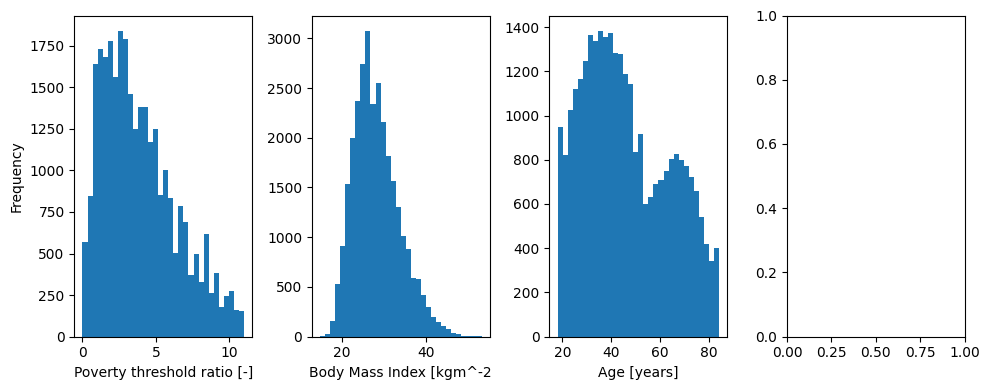

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].hist(df["poverty"], bins=32)
axs[1].hist(df["bmi"], bins=32)
axs[2].hist(df["age"], bins=32)
#axs[3].hist(df["sleep"], bins=24)

axs[0].set(xlabel="Poverty threshold ratio [-]", ylabel="Frequency")
axs[1].set(xlabel="Body Mass Index [kgm^-2")
axs[2].set(xlabel="Age [years]")
#axs[3].set(xlabel="Daily sleep [hours]")

fig.tight_layout()

C:\Users\ssepa\AppData\Local\Temp\ipykernel_8916\3374272754.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["age"]+features)
C:\Users\ssepa\AppData\Local\Temp\ipykernel_8916\3374272754.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(["age"]+features)


' a = ["parent","life_sat"]\ntable = pd.crosstab(columns=[df[x] for x in a], index=df.index).sum()\ntable '

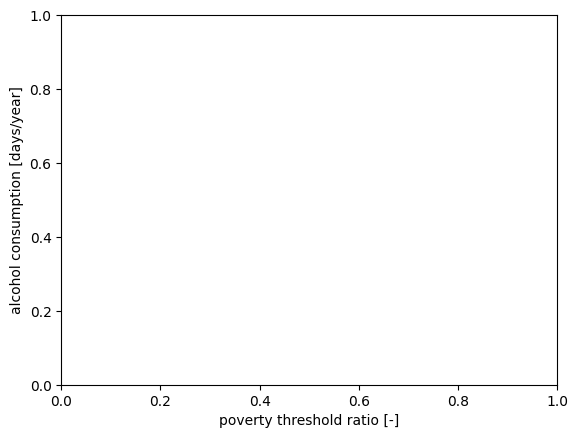

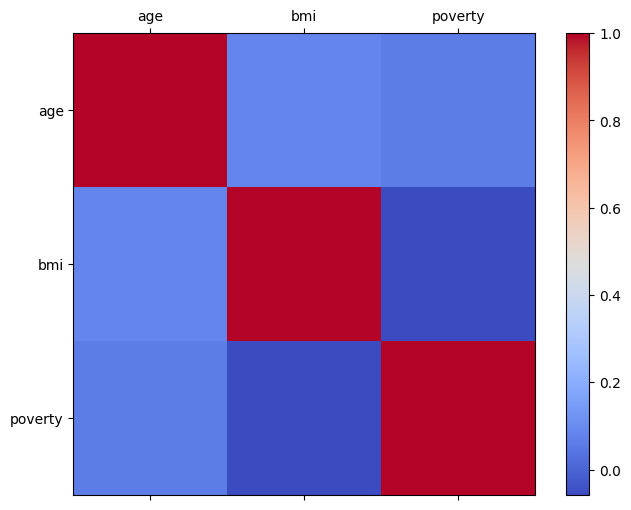

In [21]:
fig, ax = plt.subplots(1)
#ax.scatter(df["poverty"], df["alcohol"])
ax.set(xlabel="poverty threshold ratio [-]", ylabel="alcohol consumption [days/year]")


features = ["age", "bmi", "poverty"]
fig, ax = plt.subplots(1, figsize=(8, 6))
corr_matrix = df[features].corr(method="pearson")
cax = ax.matshow(corr_matrix, cmap='coolwarm')  
fig.colorbar(cax)
ax.set_xticklabels(["age"]+features)
ax.set_yticklabels(["age"]+features)
""" a = ["parent","life_sat"]
table = pd.crosstab(columns=[df[x] for x in a], index=df.index).sum()
table """

In [22]:
df["age"] = (df["age"] - df["age"].min()) / (df["age"].max() - df["age"].min())
df["poverty"] = (df["poverty"] - df["poverty"].min()) / (df["poverty"].max() - df["poverty"].min())
df["bmi"] = (df["bmi"] - df["bmi"].min()) / (df["bmi"].max() - df["bmi"].min())
df = pd.get_dummies(df, columns=["education", "anxiety", "health_sat"])

In [23]:
df

,weight,height,pregnant,age,gender,single,owns_home,parent,poverty,life_sat,...,anxiety_1,anxiety_2,anxiety_3,anxiety_4,anxiety_5,health_sat_1,health_sat_2,health_sat_3,health_sat_4,health_sat_5
1,106.594120,1.8796,NaN,0.696970,0,False,0,False,0.937216,1,...,False,False,False,True,False,False,False,True,False,False
2,98.883056,1.7526,2.0,0.287879,1,False,0,False,0.851683,0,...,False,False,True,False,False,False,False,True,False,False
10,88.450440,1.7272,NaN,0.954545,0,True,0,False,0.139217,1,...,False,False,False,True,False,False,False,True,False,False
11,90.718400,1.8034,NaN,0.757576,0,True,0,False,0.328480,0,...,False,False,False,False,True,True,False,False,False,False
18,72.574720,1.7018,NaN,0.136364,0,True,1,False,0.386715,0,...,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29513,78.017824,1.6002,2.0,0.106061,1,True,1,False,0.289354,1,...,False,True,False,False,False,False,False,True,False,False
29514,97.522280,1.7272,2.0,0.227273,1,False,0,True,0.772520,0,...,False,False,True,False,False,True,False,False,False,False
29515,90.718400,1.8796,NaN,0.393939,0,False,0,True,0.220200,0,...,False,False,True,False,False,False,True,False,False,False
29516,97.522280,1.7526,2.0,0.409091,1,True,0,True,0.315742,0,...,False,True,False,False,False,False,False,True,False,False


In [38]:
X = df.drop(["life_sat", "pregnant", "weight", "height"], axis=1)
y = df["life_sat"]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# reweighting
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weights = np.array([class_weight_dict[label] for label in y_train])

# Resample the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

""" model = XGBClassifier(
    n_estimators=1000,       # Number of boosting rounds
    learning_rate=0.2,      # Step size shrinkage
    max_depth=6,            # Maximum depth of trees
    random_state=42,        # Random seed
) """

""" model = KNeighborsClassifier(n_neighbors=11, weights="distance")
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test) """

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = MLPClassifier(
    hidden_layer_sizes=(10, 5),  # Two hidden layers with 10 and 5 neurons
    activation='relu',           # Activation function for hidden layers
    solver='lbfgs',               # Optimizer
    max_iter=300,                # Maximum iterations
    random_state=42              # For reproducibility    
)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("Accuracy score:", accuracy_score(y_true=y_test, y_pred=y_pred))
print(classification_report(y_test, y_pred))


Accuracy score: 0.5381873727087576
              precision    recall  f1-score   support

           0       0.60      0.69      0.65      2542
           1       0.65      0.42      0.51      3112
           2       0.12      0.47      0.19       198
           3       0.04      0.17      0.07        40

    accuracy                           0.54      5892
   macro avg       0.35      0.44      0.35      5892
weighted avg       0.61      0.54      0.55      5892



d:\OneDrive\Dokumenti\ITU\III.semester\DAMIN\Assignments Git Repository\datamining-2\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
